In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import numpy as np
class Network(nn.Module):
    # replica of Dr Chandra's code
    def __init__(self,input_shape,hidden_shape,output_shape):
        super().__init__()
        self.topology = (input_shape,hidden_shape,output_shape)
        self.l1 = nn.Linear(input_shape,hidden_shape)
        self.l1_act = nn.Sigmoid()
        self.l2 = nn.Linear(hidden_shape,output_shape)
        self.out_act = nn.Sigmoid()
        
        self.export_w = np.zeros(input_shape*hidden_shape+hidden_shape+hidden_shape*output_shape+output_shape)
    def forward(self,x):
        return self.out_act(self.l2(self.l1_act(self.l1(x))))
    def loss(self,output,target_label):
        # after checking with cs9444 notes, the lgmcmc loss is just a l2 loss
        return nn.MSELoss(output,target_label) # by default, pytorch uses mean
    def encode(self):
        # export weights for mcmc
        self.export_w = np.concatenate((
            self.l1.weight.data.ravel().numpy(),
            self.l1.bias.data.ravel().numpy(),
            self.l2.weight.data.ravel().numpy(),
            self.l2.bias.data.ravel().numpy(),
        ))
        return self.export_w
    def decode(self,w):
        # import weights from mcmc
        l1w = self.topology[0]*self.topology[1]
        l2w = self.topology[1]*self.topology[2]
        l2w_start = l1w+self.topology[1]
        print(len(w[0:l1w]))
        print(len(w[l1w:l1w+self.topology[1]]))
        print(len(w[l2w_start:l2w_start+self.topology[2]]))
        print(len(w[l2w_start+self.topology[2]:]))

        self.l1.weight.data = torch.from_numpy( w[0:l1w].reshape((self.topology[1],self.topology[0])))
        self.l1.bias.data   = torch.from_numpy( w[l1w:l1w+self.topology[1]])
        self.l2.weight.data = torch.from_numpy( w[l2w_start:l2w_start+l2w].reshape((self.topology[2],self.topology[1])))
        self.l2.bias.data   = torch.from_numpy( w[l2w_start+l2w:])

    def evaluate_proposal(self,data):
        
        return self(data)
class MCMC:
    pass

In [11]:
n = Network(5,10,1)
[x for x in n.parameters()]
n.parameters()

<generator object Module.parameters at 0x7f7dc6d59f90>

In [9]:
import numpy as np
help(np.random.normal)

Help on built-in function normal:

normal(...) method of numpy.random.mtrand.RandomState instance
    normal(loc=0.0, scale=1.0, size=None)
    
    Draw random samples from a normal (Gaussian) distribution.
    
    The probability density function of the normal distribution, first
    derived by De Moivre and 200 years later by both Gauss and Laplace
    independently [2]_, is often called the bell curve because of
    its characteristic shape (see the example below).
    
    The normal distributions occurs often in nature.  For example, it
    describes the commonly occurring distribution of samples influenced
    by a large number of tiny, random disturbances, each with its own
    unique distribution [2]_.
    
    .. note::
        New code should use the ``normal`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    loc : float or array_like of floats
        Mean ("centre") of the distribution

In [6]:
n = Network(5,3,2)
d = torch.from_numpy(np.array([1,2,3,4,5],dtype = 'float32'))
print(n.evaluate_proposal(d))
print(n(d))


tensor([0.4995, 0.5238], grad_fn=<SigmoidBackward>)
tensor([0.4995, 0.5238], grad_fn=<SigmoidBackward>)


In [32]:
n = Network(5,3,2)
w = n.encode()
print(n.l1.weight.data)
print(n.l1.bias.data)
print(n.l2.weight.data)
print(n.l2.bias.data)
print("------------------------")
print(n.l1.weight.data.data_ptr())
print(hex(id(n.l1.weight.data.numpy())))
print("------------------------")

n.decode(w)
print(n.l1.weight.data)
print(n.l1.bias.data)
print(n.l2.weight.data)
print(n.l2.bias.data)
print("------------------------")
print(n.l1.weight.data.data_ptr())
print(hex(id(n.l1.weight.data.numpy())))

tensor([[-0.1113, -0.2503, -0.1069,  0.4155, -0.1043],
        [-0.2677, -0.2647, -0.2123,  0.0729, -0.3985],
        [-0.2636, -0.3600,  0.1263,  0.0928, -0.1728]])
tensor([-0.1262, -0.0842, -0.3052])
tensor([[-0.2671, -0.5293, -0.4061],
        [ 0.4941,  0.2802, -0.3054]])
tensor([ 0.1598, -0.4857])
------------------------
94041948193600
0x7f291bc2de70
------------------------
15
3
2
6
tensor([[-0.1113, -0.2503, -0.1069,  0.4155, -0.1043],
        [-0.2677, -0.2647, -0.2123,  0.0729, -0.3985],
        [-0.2636, -0.3600,  0.1263,  0.0928, -0.1728]])
tensor([-0.1262, -0.0842, -0.3052])
tensor([[-0.2671, -0.5293, -0.4061],
        [ 0.4941,  0.2802, -0.3054]])
tensor([ 0.1598, -0.4857])
------------------------
94041948220192
0x7f291bc59f90


In [17]:
type(n.l1.weight.data)
x = np.array([1,2,3])
print(x.ndim,x.shape)

1 (3,)


In [14]:
def f(a,b,c):
    print(a,b,c)
f(*[1,2,3])

1 2 3


In [25]:
import torch

1/torch.distributions.Normal(2,2).sample()




tensor(0.3017)

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import random
import time
from scipy.stats import multivariate_normal
from scipy.stats import norm
import math
import os
class FC(nn.Module):
    # replica of Dr Chandra's code
    def __init__(self,layer_shapes,activation = nn.Sigmoid, out_act = nn.Sigmoid):
        super().__init__()
        self.topology = layer_shapes
        self.layerslist = []
        for i,x in enumerate(self.topology):
            if i != (len(self.topology)-1):
                self.layerslist.append(nn.Linear(*x))
                self.layerslist.append(activation())
            else:
                self.layerslist.append(nn.Linear(*x))
                self.layerslist.append(out_act())
        self.nn = nn.Sequential(*self.layerslist)

    def forward(self,x):
        return self.nn(x)
    def encode(self):
        return torch.cat([x.flatten() for x in self.parameters()])
    def decode(self,w):
        cumidx = 0
        for p in self.parameters():
            nneurons = torch.numel(p)
            p.data = w[cumidx:nneurons].reshape(p.data.shape)
            cumidx += nneurons
class MCMC:
    def __init__(self,trainx,trainy,testx,testy, use_langevin,langevin_prob,learning_rate,n_full_batches,networktype = 'fc', hidden_size = [5] ):
        """ assumes that y is normally distributed with mean represented by nn model:
            unknowns:
                tau - sd of y
                w - weights and bias 
            hyperparameters - a,b, Sigma

            # in Dr Chandra's paper, theta = (weight,bias,tau (y sample variance) )
            # here it's different

            p(y_S|w,tau) = 1/(2pi tau^2)^(S/2) * exp(-(sum (y_t - f(x_t))^2)/(2tau^2))
            p(w1,...wn) ~ N(0_, Sigma_) , Sigma = covar matrix
            p(w1,...wn) ~ 1/(2pi sigma^2)^n exp(()/2)
            tau^2 ~ IGamma(a,b) => 1/tau ~ Gamma(a,b)
            now we want to simulate p(w|x,y,tau)
            mcmc steps:
                # i want to use gibb sample for tau_i|w_i-1,y,x
                # the code by Dr Chandra uses normal proposal for tau instead that might be easier to evaluate.
                # both proposal distribution by R.C uses a step for std. 

                propose w|tau,y,x from N(w_ld,)
                accept-reject
            
        Args:
            trainx ([ndarray]): [description]
            trainy ([ndarray]): [description]
            testx ([ndarray]): [description]
            testy ([ndarray]): [description]
            use_langevin ([bool]): [description]
            langevin_prob ([float32:[0,1])]): [description]
            learning_rate ([float32]): [description]
            n_full_batches ([int]): [description]
            networktype (str, optional): [description]. Defaults to 'fc'.
            hidden_size (list, optional): [not including input layer(data) size and output layer size]. Defaults to [5].
        """

        self.trainx = trainx if isinstance(trainx,torch.Tensor) else torch.from_numpy(trainx)
        self.trainy = trainy if isinstance(trainy,torch.Tensor) else torch.from_numpy(trainy)
        self.testx  = testx  if isinstance(testx,torch.Tensor)  else torch.from_numpy(testx)
        self.testy  = testy  if isinstance(testy,torch.Tensor)  else torch.from_numpy(testy)
        self.use_langevin = use_langevin
        self.langevin_prob = langevin_prob
        self.lr = learning_rate
        self.n_iter = n_full_batches

        self.networktype = networktype
        if networktype == 'fc':            
            self.network_shape = []
            self.n_weights = 0
            for i,x in enumerate(hidden_size):
                if i == 0:
                    self.network_shape.append((trainx.shape[-1],x))
                    self.n_weights += trainx.shape[-1]*x+x
                else:
                    self.network_shape.append((hidden_size[i-1],x))
                    self.n_weights += hidden_size[i-1]*x+x
                if i == (len(hidden_size)-1):
                    shape = (x,1 if testy.ndim == 1 else testy.shape[-1] )
                    self.network_shape.append(shape)
                    self.n_weights += shape[0]*shape[1]+shape[1]
            self.network = FC(self.network_shape)
            
            self.loss = nn.MSELoss()
    def p_theta(self): # p(theta)
        ...
    def p_theta_x(self): # p(theta|X)
        ...
    def p_x_theta(self): # p(X|theta)
        ...
    def proposal(self): # p(theta*|theta_t)
        ...
    def randomwalkproposal(self):
        ...
    def sample(self, a,b,sigma2):
        """[summary]

        Args:
            a ([type]): [param for tau prior]
            b ([type]): [param for tau prior]
            sigma2 ([type]): [param for w prior]
        """
        # uses default torch init for weights and sample variance as starter (i.e. null model)
        predY = self.network(self.trainx)
        tau2 = np.zeros(self.n_iter)
        tau2[0] = np.var(self.trainy) #np.random.rand(np.var(self.trainy))+0.00001

        tau_posterior_a = self.n_weights + a + 1
        for i in range(1,self.n_iter+1):
            tau_posterior_b = b + sum((self.trainy-predY)**2)/2
            tau2[i] = 1/torch.Gamma(tau_posterior_a,tau_posterior_b).sample() # 1/ for inverse gamma
            
            # now we propose w
            
from torchinfo import summary
if __name__ == '__main__':
    mcmc = MCMC(np.zeros((100,5)),np.zeros((100,1)),np.zeros((100,5)),np.zeros((100,1)),True,1,0.01,1000,networktype='fc',hidden_size=[8,5,2])
    print(mcmc.network)
    batch_size = 10
    summary(mcmc.network,input_size=(batch_size,5))
    w = mcmc.network.encode()
    neww = torch.tensor((), dtype=torch.int32)
    neww = neww.new_ones(w.shape).cumsum(dim=0)
    #print(w.shape)
    #print(neww)
    mcmc.network.decode(neww)
    print("-----Original----")
    print([x for x in mcmc.network.parameters()])
    extract_w = mcmc.network.encode()
    mcmc.network.decode(extract_w)
    print("-----Decode----")
    print([x for x in mcmc.network.parameters()])
    
    

FC(
  (nn): Sequential(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=8, out_features=5, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=5, out_features=2, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=2, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


RuntimeError: shape '[8]' is invalid for input of size 0

In [5]:
import torch
torch.zeros((3,2))

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

In [18]:

torch.distributions.Normal(torch.cumsum(torch.ones(10),0),10).rsample((10,)).shape

torch.Size([10, 10])

In [22]:
if torch.exp(torch.tensor(1))>1:
    print("haha")

haha


In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import random
import time
from scipy.stats import multivariate_normal
from scipy.stats import norm
import math
import os
class FC(nn.Module):
    # replica of Dr Chandra's code
    def __init__(self,layer_shapes,activation = nn.Sigmoid, out_act = nn.Sigmoid):
        super().__init__()
        self.topology = layer_shapes
        self.layerslist = []
        for i,x in enumerate(self.topology):
            if i != (len(self.topology)-1):
                self.layerslist.append(nn.Linear(*x))
                self.layerslist.append(activation())
            else:
                self.layerslist.append(nn.Linear(*x))
                self.layerslist.append(out_act())
        self.nn = nn.Sequential(*self.layerslist)

    def forward(self,x):
        return self.nn(x)
    def encode(self):
        return torch.cat([x.flatten() for x in self.parameters()])
    def decode(self,w):
        cumidx = 0
        for p in self.parameters():
            nneurons = torch.numel(p)
            p.data = w[cumidx:cumidx+nneurons].reshape(p.data.shape)
            cumidx += nneurons
class MCMC:
    def __init__(self,trainx,trainy,testx,testy, use_langevin,langevin_prob,learning_rate,n_full_batches,networktype = 'fc', hidden_size = [5] ):
        """ assumes that y is normally distributed with mean represented by nn model:
            unknowns:
                tau - sd of y
                w - weights and bias 
            hyperparameters - a,b, Sigma

            # in Dr Chandra's paper, theta = (weight,bias,tau (y sample variance) )
            # here it's different

            p(y_S|w,tau) = 1/(2pi tau^2)^(S/2) * exp(-(sum (y_t - f(x_t))^2)/(2tau^2))
            p(w1,...wn) ~ N(0_, Sigma_) , Sigma = covar matrix
            p(w1,...wn) ~ 1/(2pi sigma^2)^n exp(()/2)
            tau^2 ~ IGamma(a,b) => 1/tau ~ Gamma(a,b)
            now we want to simulate p(w|x,y,tau)
            mcmc steps:
                # i want to use gibb sample for tau_i|w_i-1,y,x
                # the code by Dr Chandra uses normal proposal for tau instead that might be easier to evaluate.
                # both proposal distribution by R.C uses a step for std. 

                for neww|tau,y,x 
                propose w*|wi ~ N(wi+sgd,sigma2)
                calc diff in proposal probability: - -N(wi+sgd,sigma2)(w*)
                accept-reject
            
        Args:
            trainx ([ndarray]): [description]
            trainy ([ndarray]): [description]
            testx ([ndarray]): [description]
            testy ([ndarray]): [description]
            use_langevin ([bool]): [description]
            langevin_prob ([float32:[0,1])]): [description]
            learning_rate ([float32]): [description]
            n_full_batches ([int]): [description]
            networktype (str, optional): [description]. Defaults to 'fc'.
            hidden_size (list, optional): [not including input layer(data) size and output layer size]. Defaults to [5].
        """

        self.trainx = trainx if isinstance(trainx,torch.Tensor) else torch.from_numpy(trainx)
        self.trainy = trainy if isinstance(trainy,torch.Tensor) else torch.from_numpy(trainy)
        self.testx  = testx  if isinstance(testx,torch.Tensor)  else torch.from_numpy(testx)
        self.testy  = testy  if isinstance(testy,torch.Tensor)  else torch.from_numpy(testy)
        self.use_langevin = use_langevin
        self.langevin_prob = langevin_prob
        self.lr = learning_rate
        self.n_iter = n_full_batches

        self.networktype = networktype
        if networktype == 'fc':            
            self.network_shape = []
            self.n_weights = 0
            for i,x in enumerate(hidden_size):
                if i == 0:
                    self.network_shape.append((trainx.shape[-1],x))
                    self.n_weights += trainx.shape[-1]*x+x
                else:
                    self.network_shape.append((hidden_size[i-1],x))
                    self.n_weights += hidden_size[i-1]*x+x
                if i == (len(hidden_size)-1):
                    shape = (x,1 if testy.ndim == 1 else testy.shape[-1] )
                    self.network_shape.append(shape)
                    self.n_weights += shape[0]*shape[1]+shape[1]
            self.network = FC(self.network_shape)
            
            self.loss = nn.MSELoss()
            self.optimiser = torch.optim.SGD(self.network.parameters(),lr = learning_rate)
    def log_y_likelihood(self,w,tau2,x,y):
        self.network.decode(w.clone())
        predy = self.network(x)
        return [torch.log(torch.sqrt(tau2))*len(y)/2 - torch.sum( (y-predy)**2)/(2*tau2), predy ,self.loss(y,predy)]
    def sample(self, a,b,sigma):
        """[summary]

        Args:
            a ([type]): [param for tau prior]
            b ([type]): [param for tau prior]
            sigma ([type]): [param for w prior]
        """
        # uses default torch init for weights and sample variance as starter (i.e. null model)
        predY = torch.zeros((self.n_iter,len(self.trainy)))
        predY[0,:] = self.network(self.trainx).flatten()

        tau2     = torch.zeros(self.n_iter)
        tau2[0]  = torch.var(self.trainy) #np.random.rand(np.var(self.trainy))+0.00001
        w_all    = torch.zeros((self.n_iter,self.n_weights))
        w_all[0,:] = self.network.encode()
        fx_test  = torch.zeros((self.n_iter,len(self.testy))) #
        fx_train = torch.zeros((self.n_iter,len(self.trainy))) # here assumes that y is one dimension

        
        w_prior = torch.distributions.Normal(torch.zeros(w_all[0,:].shape),sigma)
        
        tau_posterior_a = self.n_weights + a + 1
        

        n_accept = 0
        for i in range(1,self.n_iter):
            tau_posterior_b = b + sum((self.trainy.flatten()-predY[i-1,:])**2)/2 # flatten to change from [n,1] to [n,]
            tau2[i] = 1/torch.distributions.Gamma(tau_posterior_a,tau_posterior_b).sample() # 1/ for inverse gamma
            
            w_last = w_all[i-1,:]
            # now we propose new w
            if self.use_langevin:
                # w + delta w : w+SGD
                self.network.decode(w_last.clone())
                loss = self.loss(self.trainy,self.network(self.trainx))
                self.optimiser.zero_grad()
                loss.backward()
                self.optimiser.step()
                w_last_bar = self.network.encode()
                w_star = torch.distributions.Normal(w_last_bar,sigma).sample()
                
                self.network.decode(w_star.clone())
                loss = self.loss(trainy,self.network(self.trainx))
                self.optimiser.zero_grad()
                loss.backward()
                self.optimiser.step()
                w_star_bar = self.network.encode()
                
                # q(wi|w*)/q(w*|wi)
                log_proposal_ratio = (
                    torch.distributions.MultivariateNormal(w_star_bar,torch.eye(len(w_star_bar))*sigma).log_prob(w_last) - 
                    torch.distributions.MultivariateNormal(w_last_bar,torch.eye(len(w_star_bar))*sigma).log_prob(w_star)
                )
            else:
                w_star = torch.distribution.Normal(w[i-1,:],sigma)
                # q(wi|w*)/q(w*|wi)
                log_proposal_ratio = 0
            # pi(w*|y)/pi(wi|y) NOTE: R.C's code sampled both tau and w via MH, i'm sampling only w, hence different prior
            # pi(w*|y) \sim  pi(w*)p(y|w*)
            log_prior_ratio      = torch.sum(w_prior.log_prob(w_star)-w_prior.log_prob(w_last)) # sum of log of independent weight, wont work with covar matrix
            
            [ln_y_w_star, fx_w_star, rmse_w_star] = self.log_y_likelihood(w_star.clone(), tau2[i], self.trainx,self.trainy)
            [ln_y_w_last, fx_w_last, rmse_w_last] = self.log_y_likelihood(w_last.clone(), tau2[i], self.trainx,self.trainy)
            log_likelihood_ratio = ln_y_w_star - ln_y_w_last
        
            # to calculate the accept reject we need 
            # min(1, pi(w*|x)/pi(wi|x) *  q(wi|w*)/q(w*|wi) )
            try:
                mh_prob = min(1, torch.exp(log_proposal_ratio + log_prior_ratio + log_likelihood_ratio))
            except OverflowError as e:
                mh_prob = 1

            u = torch.rand(1)

            if u < mh_prob:
                # Update position 
                [ln_y_w_star_test, fx_w_star_test, rmse_w_star] = self.log_y_likelihood(w_star.clone(), tau2[i], self.testx,self.testy)

                n_accept += 1
                w_all[i,] = w_star
                fx_test[i,]  =  fx_w_star_test.flatten()
                fx_train[i,] = fx_w_star.flatten()
                
            else:
                w_all[i,] = w_all[i-1,]

                fx_test[i,] = fx_test[i-1,] 
                fx_train[i,]= fx_train[i-1,]
        accept_ratio = n_accept/self.n_iter
                # temporarily ignoring rmse statistic, just want to get thinks working
        return [tau2, w_all,fx_train,fx_test,accept_ratio]
from torchinfo import summary
if __name__ == '__main__':
    traindata = np.loadtxt("./Code/Bayesian_neuralnetwork-LangevinMCMC/data/Sunspot/train.txt")
    testdata = np.loadtxt("./Code/Bayesian_neuralnetwork-LangevinMCMC/data/Sunspot/test.txt")  #
    name	= "Sunspot"
    trainx = torch.from_numpy(traindata[:,:-1]).type(torch.FloatTensor)
    trainy = torch.from_numpy(traindata[:,-1]).type(torch.FloatTensor).reshape((len(traindata),1))
    testx  = torch.from_numpy(testdata[:,:-1]).type(torch.FloatTensor)
    testy  = torch.from_numpy(testdata[:,-1]).type(torch.FloatTensor).reshape((len(testdata),1))

    num_samples = 5000
    mcmc = MCMC(trainx,trainy,testx,testy,True,1,0.01,num_samples,networktype='fc',hidden_size=[4])
    print(mcmc.network)
    #batch_size = 10
    #summary(mcmc.network,input_size=(batch_size,5))

    a = 0.0001
    b = 0.0001
    sigma = 0.025
    [tau2, w_all,fx_train,fx_test,accept_ratio] = mcmc.sample(a,b,sigma)

    bp = 1

FC(
  (nn): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=4, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


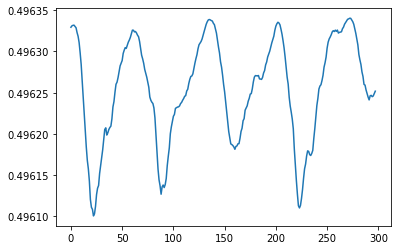

torch.Size([298, 4])

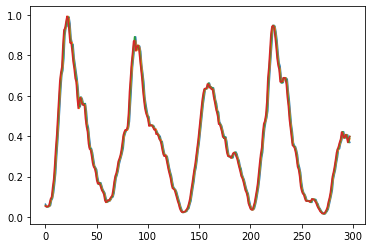

In [53]:
#plt.plot(trainy)
plt.plot(fx_train[-9,:].detach().numpy())
plt.show()
plt.plot(trainx.detach().numpy())
trainx.shape
#plt.show()

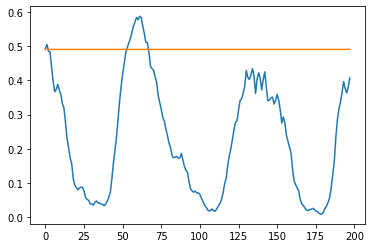

In [50]:
plt.plot(testy)
plt.plot(fx_test[-10,:].detach().numpy())
plt.show()

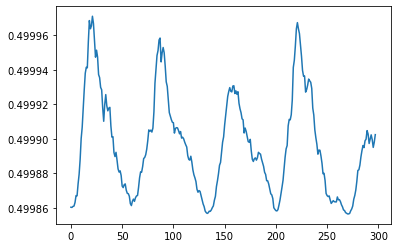

In [42]:
plt.plot(mcmc.network(mcmc.trainx).detach().numpy())


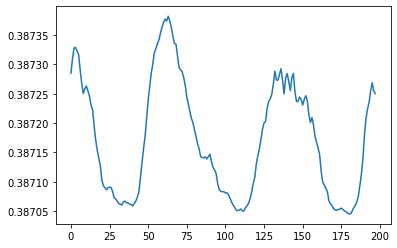

In [19]:
plt.plot(mcmc.network(mcmc.testx).detach().numpy())

In [20]:
mcmc.loss(mcmc.network(mcmc.testx),mcmc.testy)

/home/sean/miniconda3/envs/trade/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([198])) that is different to the input size (torch.Size([198, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0538, grad_fn=<MseLossBackward>)

In [33]:
#((mcmc.testy-mcmc.network(mcmc.testx)))
print(
    mcmc.testy.shape,
    mcmc.network(mcmc.testx).reshape(mcmc.testy.shape).shape
)
mcmc.testy.reshape((len(mcmc.testy),1))

torch.Size([198]) torch.Size([198])


tensor([[0.4936],
        [0.5044],
        [0.4848],
        [0.4828],
        [0.4375],
        [0.3976],
        [0.3665],
        [0.3732],
        [0.3881],
        [0.3712],
        [0.3584],
        [0.3313],
        [0.3191],
        [0.2765],
        [0.2306],
        [0.2028],
        [0.1744],
        [0.1575],
        [0.1136],
        [0.0940],
        [0.0879],
        [0.0805],
        [0.0859],
        [0.0879],
        [0.0879],
        [0.0771],
        [0.0581],
        [0.0527],
        [0.0494],
        [0.0392],
        [0.0392],
        [0.0358],
        [0.0439],
        [0.0480],
        [0.0419],
        [0.0426],
        [0.0385],
        [0.0379],
        [0.0338],
        [0.0392],
        [0.0473],
        [0.0581],
        [0.0730],
        [0.1116],
        [0.1582],
        [0.1974],
        [0.2339],
        [0.2874],
        [0.3381],
        [0.3820],
        [0.4192],
        [0.4483],
        [0.4801],
        [0.4956],
        [0.5091],
        [0

In [38]:
traindata = np.loadtxt("./Code/Bayesian_neuralnetwork-LangevinMCMC/data/Sunspot/train.txt")
testdata = np.loadtxt("./Code/Bayesian_neuralnetwork-LangevinMCMC/data/Sunspot/test.txt")  #
name	= "Sunspot"

trainx = torch.from_numpy(traindata[:,:-1]).type(torch.FloatTensor)
trainy = torch.from_numpy(traindata[:,-1]).type(torch.FloatTensor).reshape((len(trainy),1))
testx  = torch.from_numpy(testdata[:,:-1]).type(torch.FloatTensor)
testy  = torch.from_numpy(testdata[:,-1]).type(torch.FloatTensor).reshape((len(testy),1))


In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import random
import time
from scipy.stats import multivariate_normal
from scipy.stats import norm
import math
import os
class FC(nn.Module):
    # replica of Dr Chandra's code
    def __init__(self,layer_shapes,activation = nn.Sigmoid, out_act = nn.Sigmoid):
        super().__init__()
        self.topology = layer_shapes
        self.layerslist = []
        for i,x in enumerate(self.topology):
            if i != (len(self.topology)-1):
                self.layerslist.append(nn.Linear(*x))
                self.layerslist.append(activation())
            else:
                self.layerslist.append(nn.Linear(*x))
                self.layerslist.append(out_act())
        self.nn = nn.Sequential(*self.layerslist)

    def forward(self,x):
        return self.nn(x)
    def encode(self):
        return torch.cat([x.flatten() for x in self.parameters()])
    def decode(self,w):
        cumidx = 0
        for p in self.parameters():
            nneurons = torch.numel(p)
            p.data = w[cumidx:cumidx+nneurons].reshape(p.data.shape)
            cumidx += nneurons
class MCMC:
    def __init__(self,trainx,trainy,testx,testy, use_langevin,langevin_prob,learning_rate,n_full_batches,networktype = 'fc', hidden_size = [5] ):
        """ assumes that y is normally distributed with mean represented by nn model:
            unknowns:
                tau - sd of y
                w - weights and bias 
            hyperparameters - a,b, Sigma

            # in Dr Chandra's paper, theta = (weight,bias,tau (y sample variance) )
            # here it's different

            p(y_S|w,tau) = 1/(2pi tau^2)^(S/2) * exp(-(sum (y_t - f(x_t))^2)/(2tau^2))
            p(w1,...wn) ~ N(0_, Sigma_) , Sigma = covar matrix
            p(w1,...wn) ~ 1/(2pi sigma^2)^n exp(()/2)
            tau^2 ~ IGamma(a,b) => 1/tau ~ Gamma(a,b)
            now we want to simulate p(w|x,y,tau)
            mcmc steps:
                # i want to use gibb sample for tau_i|w_i-1,y,x
                # the code by Dr Chandra uses normal proposal for tau instead that might be easier to evaluate.
                # both proposal distribution by R.C uses a step for std. 

                for neww|tau,y,x 
                propose w*|wi ~ N(wi+sgd,sigma2)
                calc diff in proposal probability: - -N(wi+sgd,sigma2)(w*)
                accept-reject
            
        Args:
            trainx ([ndarray]): [description]
            trainy ([ndarray]): [description]
            testx ([ndarray]): [description]
            testy ([ndarray]): [description]
            use_langevin ([bool]): [description]
            langevin_prob ([float32:[0,1])]): [description]
            learning_rate ([float32]): [description]
            n_full_batches ([int]): [description]
            networktype (str, optional): [description]. Defaults to 'fc'.
            hidden_size (list, optional): [not including input layer(data) size and output layer size]. Defaults to [5].
        """

        self.trainx = trainx if isinstance(trainx,torch.Tensor) else torch.from_numpy(trainx)
        self.trainy = trainy if isinstance(trainy,torch.Tensor) else torch.from_numpy(trainy)
        self.testx  = testx  if isinstance(testx,torch.Tensor)  else torch.from_numpy(testx)
        self.testy  = testy  if isinstance(testy,torch.Tensor)  else torch.from_numpy(testy)
        self.use_langevin = use_langevin
        self.langevin_prob = langevin_prob
        self.lr = learning_rate
        self.n_iter = n_full_batches

        self.networktype = networktype
        if networktype == 'fc':            
            self.network_shape = []
            self.n_weights = 0
            for i,x in enumerate(hidden_size):
                if i == 0:
                    self.network_shape.append((trainx.shape[-1],x))
                    self.n_weights += trainx.shape[-1]*x+x
                else:
                    self.network_shape.append((hidden_size[i-1],x))
                    self.n_weights += hidden_size[i-1]*x+x
                if i == (len(hidden_size)-1):
                    shape = (x,1 if testy.ndim == 1 else testy.shape[-1] )
                    self.network_shape.append(shape)
                    self.n_weights += shape[0]*shape[1]+shape[1]
            self.network = FC(self.network_shape)
            
            self.loss = nn.MSELoss()
            self.optimiser = torch.optim.SGD(self.network.parameters(),lr = learning_rate)
    def log_y_likelihood(self,w,tau2,x,y):
        self.network.decode(w.clone())
        predy = self.network(x)
        return [torch.log(torch.sqrt(tau2))*len(y)/2 - torch.sum( (y-predy)**2)/(2*tau2), predy ,self.loss(y,predy)]
    def sample(self, a,b,sigma):
        """[summary]

        Args:
            a ([type]): [param for tau prior]
            b ([type]): [param for tau prior]
            sigma ([type]): [param for w prior]
        """
        # uses default torch init for weights and sample variance as starter (i.e. null model)
        predY = torch.zeros((self.n_iter,len(self.trainy)))
        predY[0,:] = self.network(self.trainx).flatten()

        tau2     = torch.zeros(self.n_iter)
        tau2[0]  = torch.var(self.trainy) #np.random.rand(np.var(self.trainy))+0.00001
        w_all    = torch.zeros((self.n_iter,self.n_weights))
        w_all[0,:] = self.network.encode()
        fx_test  = torch.zeros((self.n_iter,len(self.testy))) #
        fx_train = torch.zeros((self.n_iter,len(self.trainy))) # here assumes that y is one dimension

        
        w_prior = torch.distributions.Normal(torch.zeros(w_all[0,:].shape),sigma)
        
        tau_posterior_a = self.n_weights + a + 1
        

        n_accept = 0
        for i in range(1,self.n_iter):
            tau_posterior_b = b + sum((self.trainy.flatten()-predY[i-1,:])**2)/2 # flatten to change from [n,1] to [n,]
            tau2[i] = 1/torch.distributions.Gamma(tau_posterior_a,tau_posterior_b).sample() # 1/ for inverse gamma
            
            w_last = w_all[i-1,:]
            # now we propose new w
            if self.use_langevin:
                # w + delta w : w+SGD
                self.network.decode(w_last.clone())
                loss = self.loss(self.trainy,self.network(self.trainx))
                self.optimiser.zero_grad()
                loss.backward()
                self.optimiser.step()
                w_last_bar = self.network.encode()
                w_star = torch.distributions.Normal(w_last_bar,sigma).sample()
                
                self.network.decode(w_star.clone())
                loss = self.loss(trainy,self.network(self.trainx))
                self.optimiser.zero_grad()
                loss.backward()
                self.optimiser.step()
                w_star_bar = self.network.encode()
                
                # q(wi|w*)/q(w*|wi)
                log_proposal_ratio = (
                    torch.distributions.MultivariateNormal(w_star_bar,torch.eye(len(w_star_bar))*sigma).log_prob(w_last) - 
                    torch.distributions.MultivariateNormal(w_last_bar,torch.eye(len(w_star_bar))*sigma).log_prob(w_star)
                )
            else:
                w_star = torch.distribution.Normal(w[i-1,:],sigma)
                # q(wi|w*)/q(w*|wi)
                log_proposal_ratio = 0
            # pi(w*|y)/pi(wi|y) NOTE: R.C's code sampled both tau and w via MH, i'm sampling only w, hence different prior
            # pi(w*|y) \sim  pi(w*)p(y|w*)
            log_prior_ratio      = torch.sum(w_prior.log_prob(w_star)-w_prior.log_prob(w_last)) # sum of log of independent weight, wont work with covar matrix
            
            [ln_y_w_star, fx_w_star, rmse_w_star] = self.log_y_likelihood(w_star.clone(), tau2[i], self.trainx,self.trainy)
            [ln_y_w_last, fx_w_last, rmse_w_last] = self.log_y_likelihood(w_last.clone(), tau2[i], self.trainx,self.trainy)
            log_likelihood_ratio = ln_y_w_star - ln_y_w_last
        
            # to calculate the accept reject we need 
            # min(1, pi(w*|x)/pi(wi|x) *  q(wi|w*)/q(w*|wi) )
            try:
                mh_prob = min(1, torch.exp(log_proposal_ratio + log_prior_ratio + log_likelihood_ratio))
            except OverflowError as e:
                mh_prob = 1

            u = torch.rand(1)

            if u < mh_prob:
                # Update position 
                [ln_y_w_star_test, fx_w_star_test, rmse_w_star] = self.log_y_likelihood(w_star.clone(), tau2[i], self.testx,self.testy)

                n_accept += 1
                w_all[i,] = w_star
                fx_test[i,]  =  fx_w_star_test.flatten()
                fx_train[i,] = fx_w_star.flatten()
                
            else:
                w_all[i,] = w_all[i-1,]

                fx_test[i,] = fx_test[i-1,] 
                fx_train[i,]= fx_train[i-1,]
        accept_ratio = n_accept/self.n_iter
                # temporarily ignoring rmse statistic, just want to get thinks working
        return [tau2, w_all,fx_train,fx_test,accept_ratio]
from torchinfo import summary
if __name__ == '__main__':
    traindata = np.loadtxt("./Code/Bayesian_neuralnetwork-LangevinMCMC/data/Sunspot/train.txt")
    testdata = np.loadtxt("./Code/Bayesian_neuralnetwork-LangevinMCMC/data/Sunspot/test.txt")  #
    name	= "Sunspot"
    trainx = torch.from_numpy(traindata[:,:-1]).type(torch.FloatTensor)
    trainy = torch.from_numpy(traindata[:,-1]).type(torch.FloatTensor).reshape((len(traindata),1))
    testx  = torch.from_numpy(testdata[:,:-1]).type(torch.FloatTensor)
    testy  = torch.from_numpy(testdata[:,-1]).type(torch.FloatTensor).reshape((len(testdata),1))

    num_samples = 5000
    mcmc = MCMC(trainx,trainy,testx,testy,True,1,0.01,num_samples,networktype='fc',hidden_size=[4])
    print(mcmc.network)
    #batch_size = 10
    #summary(mcmc.network,input_size=(batch_size,5))

    a = 0.1
    b = 0.1
    sigma = 3
    [tau2, w_all,fx_train,fx_test,accept_ratio] = mcmc.sample(a,b,sigma)

    bp = 1

FC(
  (nn): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=4, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


0.0036


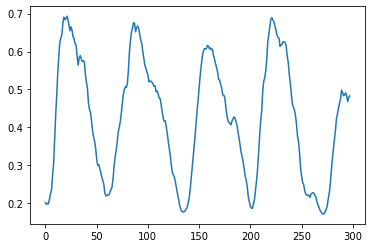

torch.Size([298, 4])

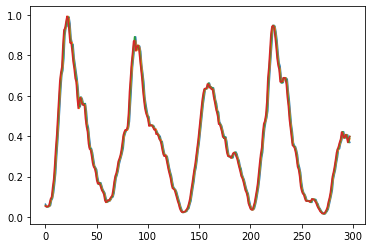

In [88]:
#plt.plot(trainy)
print(accept_ratio)
plt.plot(fx_train[-9,:].detach().numpy())
plt.show()
plt.plot(trainx.detach().numpy())
trainx.shape
#plt.show()